In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %cd /content/drive/My Drive/OriGen/origen_interview_data
# !ls /

/content/drive/My Drive/OriGen/origen_interview_data
bin			    datalab  lib     media		       proc	   sbin  tools
boot			    dev      lib32   mnt		       python-apt  srv	 usr
content			    etc      lib64   NGC-DL-CONTAINER-LICENSE  root	   sys	 var
cuda-keyring_1.0-1_all.deb  home     libx32  opt		       run	   tmp


In [74]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import os
import pandas as pd

In [4]:
def load_and_combine_npy(directory,transform = True):
    '''
    Input: Directory of different features
    Output: 0-1 normalized features split into train, test and validation along with min and max
    '''
    # List all .npy files in the directory
    npy_files = [file for file in os.listdir(directory) if file.endswith('.npy')]

    # Initialize an empty list to store the arrays
    train_array = []
    test_array = []
    valid_array = []
    counter = 0
    # Load each .npy file, reshape, and append to the list
    for file_name in npy_files:
        file_path = os.path.join(directory, file_name)
        if transform:
            array = np.load(file_path).reshape(1,1,15,25,24)
        else:
            array = np.load(file_path).reshape(1,300,7)
        if counter <450:
            train_array.append(array)
        elif counter <475 and counter >=450:
            test_array.append(array)
        else:
            valid_array.append(array)
        counter +=1
    # Concatenate all arrays along the 0th dimension
    max_value = np.max(np.concatenate(train_array, axis=0))
    min_value = np.min(np.concatenate(train_array, axis=0))
    combined_train_array = (np.concatenate(train_array, axis=0) -min_value )/(max_value-min_value)
    combined_test_array = (np.concatenate(test_array, axis=0) -min_value)/(max_value-min_value)
    combined_valid_array = (np.concatenate(valid_array, axis=0)-min_value)/(max_value-min_value)

    return combined_train_array, combined_test_array, combined_valid_array, max_value, min_value

# Use the function for each directory
PORO_train,PORO_test, PORO_valid, PORO_max, PORO_min  = load_and_combine_npy('PORO')
PERMX_train,PERMX_test, PERMX_valid, PERMX_max,PERMX_min = load_and_combine_npy('PERMX')
PERMY_train,PERMY_test, PERMY_valid, PERMY_max, PERMY_min = load_and_combine_npy('PERMY')
PERMZ_train,PERMZ_test, PERMZ_valid, PERMZ_max,PERMZ_min = load_and_combine_npy('PERMZ')
TRANX_train,TRANX_test, TRANX_valid, TRANX_max,TRANX_min = load_and_combine_npy('TRANX')
TRANY_train,TRANY_test, TRANY_valid, TRANY_max,TRANY_min  = load_and_combine_npy('TRANY')
TRANZ_train,TRANZ_test, TRANZ_valid, TRANZ_max,TRANZ_min  = load_and_combine_npy('TRANZ')
SATNUM_train,SATNUM_test, SATNUM_valid, SATNUM_max,SATNUM_min = load_and_combine_npy('SATNUM') ## SATNUM is all ones
DEPTH_train,DEPTH_test, DEPTH_valid, DEPTH_max,DEPTH_min = load_and_combine_npy('DEPTH')
PORV_train,PORV_test, PORV_valid, PORV_max,PORV_min = load_and_combine_npy('PORV')
WOPR_train,WOPR_test, WOPR_valid, WOPR_max,WOPR_min = load_and_combine_npy('WOPR',transform = False) # OUTPUT
BHP_train,BHP_test, BHP_valid, BHP_max,BHP_min = load_and_combine_npy('BHP',transform = False) # INPUT

#Print shapes to verify
print("Combined array train shape:", PORO_train.shape)
print("Combined array valid shape:", PORO_test.shape)
print("Combined array test shape:", PORO_valid.shape)

<ipython-input-4-38a4dad0b0f6>:31: RuntimeWarning: invalid value encountered in divide
  combined_train_array = (np.concatenate(train_array, axis=0) -min_value )/(max_value-min_value)
<ipython-input-4-38a4dad0b0f6>:32: RuntimeWarning: invalid value encountered in divide
  combined_test_array = (np.concatenate(test_array, axis=0) -min_value)/(max_value-min_value)
<ipython-input-4-38a4dad0b0f6>:33: RuntimeWarning: invalid value encountered in divide
  combined_valid_array = (np.concatenate(valid_array, axis=0)-min_value)/(max_value-min_value)


Combined array train shape: (450, 1, 15, 25, 24)
Combined array valid shape: (25, 1, 15, 25, 24)
Combined array test shape: (25, 1, 15, 25, 24)


In [62]:
## Calculate mean and standard deviation for each feature
print(PORO_train.mean(), PORO_train.std())
print(PERMX_train.mean(), PERMX_train.std())
print(PERMY_train.mean(), PERMY_train.std())
print(PERMZ_train.mean(), PERMZ_train.std())
print(TRANX_train.mean(), TRANX_train.std())
print(TRANY_train.mean(), TRANY_train.std())
print(TRANZ_train.mean(), TRANZ_train.std())
print(SATNUM_train.mean(),SATNUM_train.std())
print(DEPTH_train.mean(),DEPTH_train.std())
print(PORV_train.mean(), PORV_train.std())
print(BHP_train.mean(), BHP_train.std())
print(WOPR_train.mean(), WOPR_train.std())

## We notice that SATNUM has the same value for all its elements. So, we are going to ignore it
## Also DEPTH feature just contains the coordinates of the reservoir volume so we are going to ignore it

0.22097929 0.2080207
0.031196294 0.06660703
0.031176684 0.06657632
0.031197013 0.06654759
0.009014356 0.02943098
0.0082099205 0.027926432
0.0056362017 0.028548965
nan nan
0.47945732 0.24695912
0.058708284 0.09297525
0.2913405966840637 0.22453121258911946
0.07554001231200162 0.10353787300887804


In [41]:
train_input = np.concatenate((PORO_train, PERMX_train, PERMY_train,PERMZ_train, TRANX_train, TRANY_train,
                                TRANZ_train, PORV_train),axis=1)
valid_input = np.concatenate((PORO_valid, PERMX_valid, PERMY_valid,PERMZ_valid, TRANX_valid, TRANY_valid,
                                TRANZ_valid, PORV_valid),axis=1)
test_input = np.concatenate((PORO_test, PERMX_test, PERMY_test,PERMZ_test, TRANX_test, TRANY_test,
                                TRANZ_test, PORV_test),axis=1)

In [56]:
# Define the target shape and block size for coarse-graining
def course_grain(input_data):
    '''
    Input: Data of shape [450/25,8,15,25,24]
    Output: Data of shape [450/25,8,15,5,8]
    '''
    target_shape = (input_data.shape[0], input_data.shape[1], 15, 5, 8)
    block_size = (1, 5, 3)
    # Initialize the coarse-grained tensor with zeros
    input_data_coarse_grained = np.zeros(target_shape)

    # Loop through the first two dimensions as is, then apply averaging over blocks for the last three dimensions
    for i in range(target_shape[0]):  # Loop over the first dimension (450)
        for j in range(target_shape[1]):  # Loop over the second dimension (8)
            for k in range(target_shape[2]):  # Loop over the third dimension (3)
                for l in range(target_shape[3]):  # Loop over the fourth dimension (5)
                    for m in range(target_shape[4]):  # Loop over the fifth dimension (3)
                        # Calculate the mean of each block
                        block = input_data[i, j,
                                      k*block_size[0]:(k+1)*block_size[0],
                                      l*block_size[1]:(l+1)*block_size[1],
                                      m*block_size[2]:(m+1)*block_size[2]]
                        input_data_coarse_grained[i, j, k, l, m] = block.mean()
    return input_data_coarse_grained
train_input_coarse_grained = course_grain(train_input)
valid_input_coarse_grained = course_grain(valid_input)
test_input_coarse_grained  = course_grain(test_input)
print(train_input_coarse_grained.shape)
print(train_input.shape)
# coarse_grained is now the tensor of shape (450, 8, 15, 5, 8)


(450, 8, 15, 5, 8)
(450, 8, 15, 25, 24)


In [58]:
## Calcualting percentage change in standard deviation due to coarse graining
print((train_input[:,0,:,:,:].std()-train_input_coarse_grained[:,0,:,:,:].std())/train_input[:,0,:,:,:].std()*100)
print((train_input[:,1,:,:,:].std()-train_input_coarse_grained[:,1,:,:,:].std())/train_input[:,1,:,:,:].std()*100)
print((train_input[:,2,:,:,:].std()-train_input_coarse_grained[:,2,:,:,:].std())/train_input[:,2,:,:,:].std()*100)
print((train_input[:,3,:,:,:].std()-train_input_coarse_grained[:,3,:,:,:].std())/train_input[:,3,:,:,:].std()*100)
print((train_input[:,4,:,:,:].std()-train_input_coarse_grained[:,4,:,:,:].std())/train_input[:,4,:,:,:].std()*100)
print((train_input[:,5,:,:,:].std()-train_input_coarse_grained[:,5,:,:,:].std())/train_input[:,5,:,:,:].std()*100)
print((train_input[:,6,:,:,:].std()-train_input_coarse_grained[:,6,:,:,:].std())/train_input[:,6,:,:,:].std()*100)
print((train_input[:,7,:,:,:].std()-train_input_coarse_grained[:,7,:,:,:].std())/train_input[:,7,:,:,:].std()*100)

## Percentage change in standard deviation is mostly less than 20% even though we've reduced the data size by a factor of 15

16.416706794397236
17.743520694695217
17.77113079480156
17.766487854057296
17.1469753781077
17.177123637417534
25.372908608290253
9.410937022325697


In [59]:
#Converting 5d data to 4d
train_input = train_input_coarse_grained.reshape(train_input.shape[0],train_input.shape[1],train_input.shape[2],-1)
valid_input = valid_input_coarse_grained.reshape(valid_input.shape[0],train_input.shape[1],train_input.shape[2],-1)
test_input = test_input_coarse_grained.reshape(test_input.shape[0],train_input.shape[1],train_input.shape[2],-1)
print(train_input.shape)

(450, 8, 15, 40)


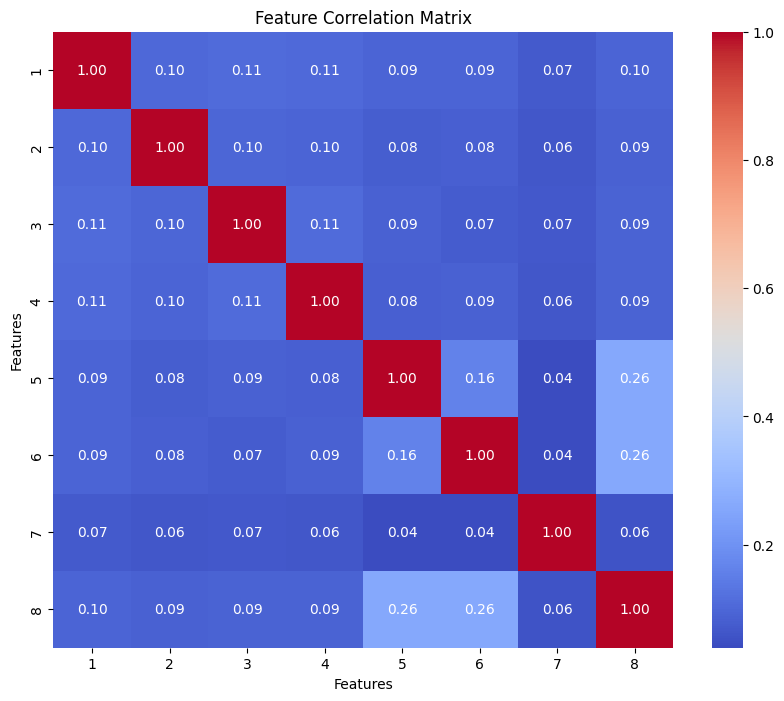

In [60]:
## Plotting average correlation matrix
num_features = 8
TIME_i = 0
TIME = 450
accumulator = np.zeros((num_features, num_features))
for i in range(TIME_i,TIME):
    out = train_input_coarse_grained[i,:,:,:].reshape(num_features,-1)
    correlation_matrix = np.abs(np.corrcoef(out))
    accumulator += correlation_matrix  # Accumulate the sum of correlation matrices
average_correlation_matrix = accumulator / (TIME-TIME_i)
import pandas as pd

# Convert to DataFrame for easier correlation computation
df = pd.DataFrame(out.T)  # Transpose to get features as columns
correlation_matrix = df.corr().values  # Compute correlation matrix and get as numpy array
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for a nicer-looking heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(average_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title('Feature Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

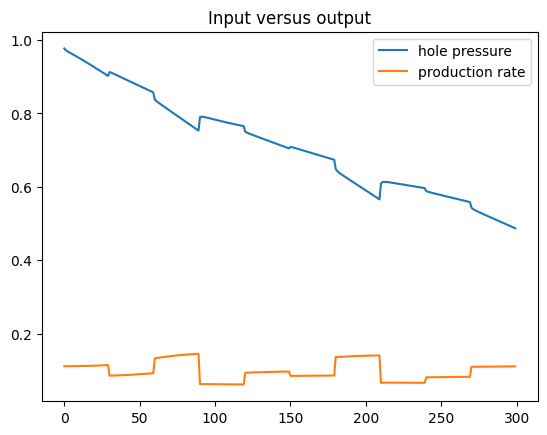

In [73]:
plt.plot(BHP_train[30, :, 0], label='hole pressure')
plt.plot(WOPR_train[30, :, 0], label='production rate')
# Add a legend to the plot
plt.legend()

# Add a title to the plot
plt.title('Input versus output')

# Display the plot
plt.show()

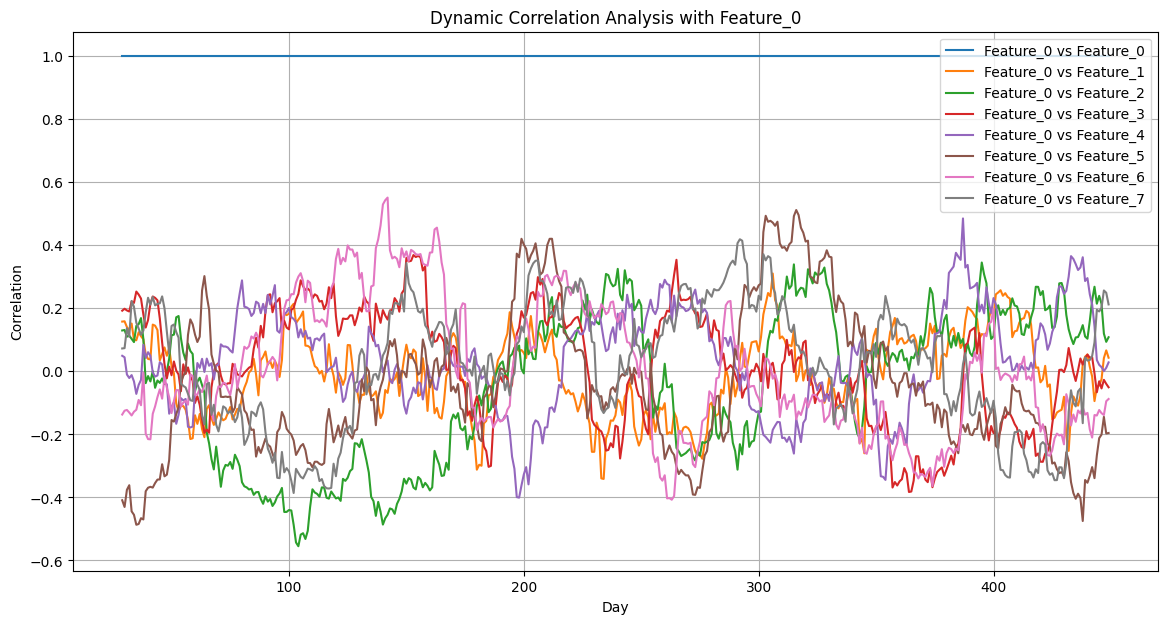

In [75]:
# Let's calculate the mean across the volume dimensions for each feature and realization
data = train_input
data_mean = data.mean(axis=(2, 3))  # New shape will be [450, 8]

# Convert to DataFrame for easier handling
df = pd.DataFrame(data_mean, columns=[f'Feature_{i}' for i in range(8)])
window_size = 30  # Example window size

plt.figure(figsize=(14, 7))

# Loop over features, skipping the first one since we're comparing all features against it
for i in range(0, 8):
    # Calculate rolling correlation with Feature_0
    rolling_corr = df[f'Feature_0'].rolling(window=window_size).corr(df[f'Feature_{i}'])
    plt.plot(rolling_corr, label=f'Feature_0 vs Feature_{i}')

plt.xlabel('Day')
plt.ylabel('Correlation')
plt.title('Dynamic Correlation Analysis with Feature_0')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
class CustomDataset(Dataset):
    def __init__(self, feature_inputs,pressure_input, outputs):
        self.feature_inputs = feature_inputs
        self.pressure_input = pressure_input
        self.outputs = outputs

    def __len__(self):
        return len(self.feature_inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.feature_inputs[idx], dtype=torch.float32)
        y = torch.tensor(self.pressure_input[idx], dtype=torch.float32)
        z = torch.tensor(self.outputs[idx], dtype=torch.float32)
        return x, y, z

train_dataset = CustomDataset(train_input,BHP_train, WOPR_train)
valid_dataset = CustomDataset(valid_input,BHP_valid, WOPR_valid)
test_dataset = CustomDataset(test_input,BHP_test, WOPR_test)

train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=25, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=False)

In [88]:
class Conv2DNet(nn.Module):
    def __init__(self):
        super(Conv2DNet, self).__init__()
        # Replace Conv3d with Conv2d
        self.conv2d1 = nn.Conv2d(8, 12, kernel_size=(3,3), stride=2, padding=1)  # Adjust kernel_size for 2D
        self.conv2d2 = nn.Conv2d(12, 16, kernel_size=(3,3), stride=2, padding=1)  # Adjust kernel_size for 2D
        self.conv2d3 = nn.Conv2d(16, 20, kernel_size=(2,2), stride=1, padding=1)  # Adjust kernel_size for 2D

        self.combiner = nn.Linear(2900, 2600)
        self.fc0 = nn.Linear(2100, 1800)

        # Additional layers after combining x and y
        self.fc1 = nn.Linear(2600, 2300)
        self.fc2 = nn.Linear(2300, 300*7)

    def forward(self, x, y):
        # Process the data x with 2D convolutions and pooling
        x = (F.relu(self.conv2d1(x)))
        x = (F.relu(self.conv2d2(x)))
        x = (F.relu(self.conv2d3(x)))

        # Flatten the output
        x = torch.flatten(x, 1)

        # Flatten y to combine it with the conv2d output
        y = torch.flatten(y, 1)
        y = F.relu(self.fc0(y))
        # Combine x and y
        combined = torch.cat((x, y), dim=1)
        combined = F.relu(self.combiner(combined))

        # Process the combined data with additional layers
        combined = F.relu(self.fc1(combined))
        output = self.fc2(combined)

        # Reshape output to match the desired shape
        output = output.view(-1, 300, 7)
        return output

In [89]:
model = Conv2DNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100  # Set the number of epochs
loss_function = nn.MSELoss()

def train(model, train_loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss_accumulated = 0.0
    for inputs,pressure, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, pressure)
        # Physics-informed loss
        # MSE loss
        MSE_loss = loss_function(outputs, targets)
        # Total loss
        total_loss = MSE_loss
        total_loss.backward()
        optimizer.step()
        total_loss_accumulated += total_loss.item()
    average_loss = total_loss_accumulated / len(train_loader)
    return average_loss
def validate(model, valid_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss_accumulated = 0.0
    with torch.no_grad():
        for inputs, pressure, targets in valid_loader:
            outputs = model(inputs, pressure)
            # MSE loss
            MSE_loss = loss_function(outputs, targets)
            # Total loss
            total_loss = MSE_loss
            total_loss_accumulated += total_loss.item()
    average_loss = total_loss_accumulated / len(valid_loader)
    return average_loss

def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss_accumulated = 0.0
    with torch.no_grad():
        for inputs, pressure, targets in test_loader:
            outputs = model(inputs, pressure)
            # MSE loss
            MSE_loss = loss_function(outputs, targets)
            # Total loss
            total_loss = MSE_loss
            total_loss_accumulated += total_loss.item()
    average_loss = total_loss_accumulated / len(test_loader)
    return average_loss, outputs.reshape(25,7,300)

train_losses = []
valid_losses = []
test_losses  = []
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    train_loss = train(model, train_loader, optimizer)
    valid_loss = validate(model, valid_loader)
    test_loss, test_output = test(model, test_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_losses.append(test_loss)



Epochs: 100%|██████████| 100/100 [17:05<00:00, 10.26s/it]


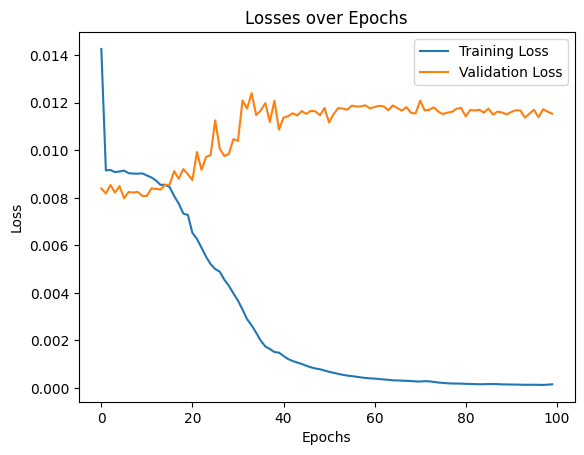

In [90]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
well_production = test_output * (WOPR_max - WOPR_min) + WOPR_min
np.save('/content/drive/MyDrive/OriGen/results_test.npy', well_production)
np.save('/content/drive/MyDrive/OriGen/loss_training.npy', train_losses)
np.save('/content/drive/MyDrive/OriGen/loss_testing.npy', test_losses)
